<h1 style="text-align: center;">Feature Engineering - CASH-OUT

## Configs

In [1]:
## Importando Pacotes
import time
tic_geral = time.time()

import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import duckdb
from tqdm import tqdm
from matplotlib.ticker import FormatStrFormatter    
import re
from validate_docbr import CPF, CNPJ
from sklearn.model_selection import train_test_split

from utils.feature_enginneering import *

## Configs
warnings.filterwarnings('ignore')
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

seed = 123

In [2]:
file_path = 'dados/df_merged.parquet'
df = pd.read_parquet(f'{file_path}')

df['last_status'] = np.where(df['fraud'] == 1, 'FRAUD', df['last_status'])
df['last_status'].value_counts(dropna=False)


last_status
APPROVED           10092969
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
Name: count, dtype: int64

- base do delorean, todos payers e receivers sem duplicados 
- tudo texto, com zeros a esquerda
- base sample 100 casos, pra Bea testar
- formato csv

tipo, documento
1,   cpf
2,   cnpj

#### Criando base para consulta do RC06

In [174]:
df_payer = df[['transaction_payer_registration_data_doc',  'transaction_payer_registration_data_doc_type']]
df_receiver = df[['transaction_receiver_registration_data_doc',  'transaction_receiver_registration_data_doc_type']]


In [175]:
df_payer['transaction_payer_registration_data_doc_type'].value_counts()

transaction_payer_registration_data_doc_type
cnpj    10093437
Name: count, dtype: int64

In [176]:
df_receiver['transaction_receiver_registration_data_doc_type'].value_counts()

transaction_receiver_registration_data_doc_type
cpf     5896199
cnpj    2629219
Name: count, dtype: int64

In [177]:
df_payer['tipo'] = np.where(df['transaction_payer_registration_data_doc_type'] == 'cpf', '1', 
                            np.where(df['transaction_payer_registration_data_doc_type'] == 'cnpj', '2', '0')
                            )
df_payer = df_payer.rename(columns={'transaction_payer_registration_data_doc': 'documento'})              
                            
                            
                            
df_receiver['tipo'] = np.where(df['transaction_receiver_registration_data_doc_type'] == 'cpf', '1', 
                            np.where(df['transaction_receiver_registration_data_doc_type'] == 'cnpj', '2', '0')
                            )

df_receiver = df_receiver.rename(columns={'transaction_receiver_registration_data_doc': 'documento'})        

In [178]:
df_payer

,documento,transaction_payer_registration_data_doc_type,tipo
0,19152814000170,cnpj,2
1,19152814000170,cnpj,2
2,19152814000170,cnpj,2
3,19152814000170,cnpj,2
4,19152814000170,cnpj,2
...,...,...,...
10110809,22831673000126,None,0
10110810,22831673000126,None,0
10110811,22831673000126,None,0
10110812,27084098000169,None,0


In [179]:
df_receiver

,documento,transaction_receiver_registration_data_doc_type,tipo
0,43286160300,cpf,1
1,96803231372,cpf,1
2,36511714349,cpf,1
3,02259500307,cpf,1
4,27929701387,cpf,1
...,...,...,...
10110809,22831673000126,None,0
10110810,22831673000126,None,0
10110811,22831673000126,None,0
10110812,07932226996,None,0


In [180]:
docs_unicos_rc06 = pd.concat([df_payer[['tipo', 'documento']], df_receiver[['tipo', 'documento']]], ignore_index=True)

In [181]:
docs_unicos_rc06 = docs_unicos_rc06.drop_duplicates()
docs_unicos_rc06 = docs_unicos_rc06.dropna()
docs_unicos_rc06

,tipo,documento
0,2,19152814000170
14,2,38333425000195
27,2,05563165000195
29,2,51824919000130
31,2,31703183000135
...,...,...
20221288,0,05200869102
20221289,0,73507048000245
20221290,0,03889976000155
20221291,0,00668111000170


In [182]:
docs_unicos_rc06.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2219498 entries, 0 to 20221626
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   tipo       object
 1   documento  string
dtypes: object(1), string(1)
memory usage: 50.8+ MB


In [183]:
docs_unicos_rc06['tipo'] = np.where((docs_unicos_rc06['tipo'] == '0') & (docs_unicos_rc06['documento'].str.len() == 11), '1', 
                    np.where((docs_unicos_rc06['tipo'] == '0') & (docs_unicos_rc06['documento'].str.len() == 14), '2', docs_unicos_rc06['tipo']))

In [184]:
docs_unicos_rc06

,tipo,documento
0,2,19152814000170
14,2,38333425000195
27,2,05563165000195
29,2,51824919000130
31,2,31703183000135
...,...,...
20221288,1,05200869102
20221289,2,73507048000245
20221290,2,03889976000155
20221291,2,00668111000170


In [185]:
docs_unicos_rc06['tipo'].value_counts()

tipo
1    1946593
2     272904
0          1
Name: count, dtype: int64

In [186]:
docs_unicos_rc06[docs_unicos_rc06['documento'] == '']


,tipo,documento
12075654,2,
20204249,0,


In [187]:
## dropa celula vazia
docs_unicos_rc06 = docs_unicos_rc06[docs_unicos_rc06['tipo'] != '0']
docs_unicos_rc06 = docs_unicos_rc06.reset_index(drop=True)
docs_unicos_rc06

,tipo,documento
0,2,19152814000170
1,2,38333425000195
2,2,05563165000195
3,2,51824919000130
4,2,31703183000135
...,...,...
2219492,1,05200869102
2219493,2,73507048000245
2219494,2,03889976000155
2219495,2,00668111000170


In [189]:
docs_unicos_rc06_sample = docs_unicos_rc06.sample(100)
docs_unicos_rc06_sample.head()

,tipo,documento
1357326,1,48635723953
326672,1,25725098818
1810372,1,28914784878
2152776,1,28540302810
2135969,1,26295117821


In [194]:
docs_unicos_rc06[docs_unicos_rc06['documento'] == '']

,tipo,documento
931351,2,


In [191]:
# docs_unicos_rc06_sample.to_csv('docs_unicos_rc06_sample.csv', index=False)
# docs_unicos_rc06.to_csv('docs_unicos_rc06.csv', index=False)

#### count fraud

In [12]:
df['fraud'].value_counts(dropna=False)

fraud
NaN     10110765
1.00          49
Name: count, dtype: int64

In [13]:
df.sort_values('last_status_changed_at', ascending=False, inplace=True)
df.drop_duplicates(subset='transaction_id', keep='first', inplace=True)
df.duplicated('transaction_id').sum()

0

### Contaminação

mesmo vetor de caracteristica mas nem sempre marcado é como fraude 
o cliente final da conta bolsão 

0. extrair documentos de recebedores e enviar p/ Theo para fazer um hit 
        hit -> enriquecer docs fraudulentos
1. olhar periodo da base de fraudes que o cliente enviou e cortaria a base do delorean no memso
2. encontrar o desbalanceamento natural da base - onde tem envio de trx no delorean é estavel (nao teste) e onde tem a marcação correta (que eles enviaram) -> SMOTE
3. focar na melhoria da variavel reposta 
4. 
5. alterar o algoritmo -> 
 random_forest = 
 lgbm = 
 xgboost = 
6.  

passa os docs p/ Theo
rodar com contaminação sem smote

## EDA

## Feature Engineering

In [14]:
## Colunas de Tempo
df['hora'] = pd.to_datetime(df['transaction_datetime_request']).dt.hour.astype(int)
df['dia'] = pd.to_datetime(df['transaction_datetime_request']).dt.day.astype(int)
df['dia_semana'] = pd.to_datetime(df['transaction_datetime_request']).dt.dayofweek

In [15]:
df['hora']

0           22
1           22
2           22
3           22
4           22
            ..
10110809    12
10110810    12
10110811    12
10110812    12
10110813    17
Name: hora, Length: 10110763, dtype: int32

In [16]:
## Transação de Testex
df['test_transaction'] = np.where(df['transaction_amount_total'] <= 1, 1, 0)
df['test_transaction'].sum()

1428843

In [17]:
list_drop_model = [
'transaction_amount_total_brl', 
'payer_cnpj', 
'receiver_cpf', 
'receiver_cnpj', 
'transaction_instalments', 
'internal_created_at', 
'internal_id', 
'client_name', 
'transaction_description', 
'transaction_currency_code', 
'transaction_type', 
'transaction_channel', 
'transaction_payer_id', 
'transaction_payer_registration_data_name', 
'transaction_payer_registration_data_phone_number', 
'transaction_payer_registration_data_address_street_number', 
'transaction_payer_registration_data_address_city', 
'transaction_payer_registration_data_address_state', 
'transaction_payer_registration_data_address_street_name', 
'transaction_payer_registration_data_address_complement', 
'transaction_payer_registration_data_address_country', 
'transaction_payer_banking_data_account_type', 
'transaction_payer_banking_data_bank_code', 
'transaction_payer_pix_key_type', 
'transaction_payer_pix_key', 
'transaction_receiver_id', 
'transaction_receiver_registration_data_name', 
'transaction_receiver_registration_data_email', 
'transaction_receiver_registration_data_birthdate', 
'transaction_receiver_registration_data_address_country', 
'transaction_receiver_banking_data_account_type', 
'transaction_receiver_banking_data_bank_code', 
'transaction_receiver_pix_key_type', 
'transaction_receiver_pix_key', 
'approved_at', 
'rejected_at', 
'processed_by', 
'fraud_detected_at', 
'last_status_changed_at', 
'last_status_changed_by', 
'rules_triggered', 
'reviewer_name', 
'reviewer_email', 
'risk', 
'transaction_instalments', 
'transaction_payer_registration_data_doc_type', 
'transaction_receiver_registration_data_doc_type', 
'extra_data', 
'transaction_payer_banking_data_account_id', 
'transaction_receiver_banking_data_account_id', 
'order_items', 
'fraud_detected_by',
]

In [18]:
df_periodo_fraudes = df.drop(list_drop_model, axis='columns')

In [19]:
receivers_transfeera = ['03310768457', '00776574000903', '19037276000172',
       '11037227000128', '17283532000186', '21385258802', '43423241802',
       '52616440000171', '09785780406', '11700719459', '06571971909',
       '58038946804', '58913037874', '55503083000123', '58708580898',
       '55053937800', '52849878000108', '06204581783', '81375808591',
       '06088441798', '08609065740', '42059494000120', '97649520897',
       '49210426000169', '49271808835', '14674796750', '17644085785',
       '15017561765', '12903498784', '24800661000160', '96845694168',
       '03822236322', '23059220867', '28799936000143', '52582356000184',
       '70260107271', '48815566813', '01602265208', '51687384860',
       '31290307865']

In [20]:
df_periodo_fraudes[
    # df_periodo_fraudes['transaction_receiver_registration_data_doc'].isin(receivers_transfeera) & 
                    (df_periodo_fraudes['last_status']=='FRAUD')].transaction_receiver_registration_data_doc.isin(receivers_transfeera).value_counts()

transaction_receiver_registration_data_doc
False    33
True     16
Name: count, dtype: int64

In [21]:
df_periodo_fraudes[df_periodo_fraudes['transaction_receiver_registration_data_doc'].isin(receivers_transfeera)].shape

(25, 11)

In [22]:
contaminacao_receiver = np.where(df_periodo_fraudes['transaction_receiver_registration_data_doc'].isin(receivers_transfeera), 1, 0)
contaminacao_receiver

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
df_periodo_fraudes['transaction_receiver_registration_data_doc'].isin(receivers_transfeera)

0           False
1           False
2           False
3           False
4           False
            ...  
10110809    False
10110810    False
10110811    False
10110812    False
10110813    False
Name: transaction_receiver_registration_data_doc, Length: 10110763, dtype: bool

In [24]:
tic = time.time()

from datetime import timedelta

df_contamined = df_periodo_fraudes.sort_values(by='transaction_datetime_request').copy()
df_contamined = df_contamined.drop_duplicates()

for idx, row in df_contamined[df_contamined['last_status'].isin(['FRAUD', 'CONT_FRAUD'])].iterrows():
# for idx, row in df_contamined[df_contamined['last_status'].isin(['FRAUD', 'SUSPECTED_FRAUD', 'CONT_FRAUD'])].iterrows():
    
    # payer = row['transaction_payer_registration_data_doc']
    receiver = row['transaction_receiver_registration_data_doc']
    # start_date = row['transaction_datetime_request']
    # end_date = start_date + timedelta(days=600)

    df_contamined.loc[
        # (df_contamined['transaction_payer_registration_data_doc'] == payer) &
        # (df_contamined['transaction_receiver_registration_data_doc'].isin(receivers_transfeera)) &
        (df_contamined['transaction_receiver_registration_data_doc'] == receiver) &
        # (df_contamined['transaction_datetime_request'] > start_date) &
        # (df_contamined['transaction_datetime_request'] <= end_date) &
        (~df_contamined['last_status'].isin(['FRAUD', 'CONT_FRAUD'])),  
        'last_status'
    ] = 'CONT_FRAUD'

toc = time.time()

print(f'Tempo de Processamento: {(toc-tic)/60:.2f} minutos')


df_contamined['last_status'].value_counts(dropna=False)

Tempo de Processamento: 0.96 minutos


last_status
APPROVED           10092915
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: int64

In [25]:
df_contamined[df_contamined['last_status'] == 'CONT_FRAUD']

,transaction_id,transaction_amount_total,transaction_datetime_request,last_status,transaction_payer_registration_data_doc,transaction_receiver_registration_data_doc,fraud,hora,dia,dia_semana,test_transaction
3617318,e27084098202409181203ktruvewchw1,0.01,2024-09-18 12:03:38.537,CONT_FRAUD,32138431000105,17283532000186,NaN,12,18,2,1
941200,e27084098202410231612n2m2oovtk42,320.00,2024-10-23 16:11:59.211,CONT_FRAUD,45810578000141,11037227000128,NaN,16,23,2,0
898460,e27084098202410240710l3itromvxwb,20.00,2024-10-24 07:10:24.145,CONT_FRAUD,04721736000100,03310768457,NaN,7,24,3,0


In [26]:
df_contamined = df_contamined[df_contamined['transaction_datetime_request'] >= '2024-05-01']

In [27]:
df_periodo_fraudes['fraud'] = np.where(df_periodo_fraudes['fraud'] == 1, 1, 0)

In [28]:
df_periodo_fraudes[df_periodo_fraudes['fraud'] == 1]['transaction_amount_total'].sum()

251148.07

In [29]:
df_periodo_fraudes[df_periodo_fraudes['fraud'] == 0]['transaction_amount_total'].sum()

9036618586.390005

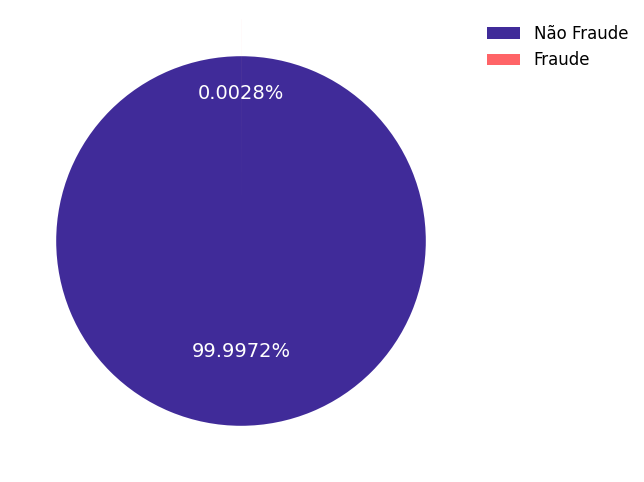

In [30]:
# Data: Classes e percentual do valor
class_labels = ['Não Fraude', 'Fraude']
class_values = [
    df_periodo_fraudes[df_periodo_fraudes['fraud'] == 0]['transaction_amount_total'].sum(),
    df_periodo_fraudes[df_periodo_fraudes['fraud'] == 1]['transaction_amount_total'].sum()
]

pos_texto = (0, 0.2)

plt.figure(figsize=(18, 6))
plt.pie(class_values, autopct='%1.4f%%', startangle=90,
        colors=['#402b99','#FF6467'], explode=pos_texto,
        textprops={'color': 'white', 'fontsize': 14})

plt.legend(class_labels, loc="upper left", bbox_to_anchor=(1, 1),
            frameon=False, fontsize=12)
plt.show()

In [31]:
df_contamined['last_status'].value_counts(dropna=False)

last_status
APPROVED           10092900
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: int64

In [32]:
df_mes = df_contamined.copy()
df_mes['mes'] = df_mes['transaction_datetime_request'].dt.month
pd.crosstab(df_mes['mes'], df_mes['last_status']) 

last_status,APPROVED,CONT_FRAUD,FRAUD,REJECTED,SUSPECTED_FRAUD
mes,,,,,
5,4886,0,0,78,0
6,1385807,0,9,2325,0
7,1950895,0,24,4258,0
8,2088929,0,3,10869,0
9,1936841,1,1,1,7
10,2314102,2,12,10,242
11,411440,0,0,0,6


In [33]:
df_mes_fraude  = df_mes[df_mes['fraud'] == 1]

pd.crosstab(df_mes_fraude['mes'], df_mes_fraude['transaction_payer_registration_data_doc']) 

transaction_payer_registration_data_doc,04721736000100,33292501000148,33440218000116,37202552000192,42971425000198,45810578000141,46250852000138,49091594000182,51957764000100
mes,,,,,,,,,
6,0,6,0,2,0,0,0,0,1
7,0,0,0,0,0,0,10,0,14
8,0,3,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0
10,1,0,2,0,0,8,0,1,0


In [34]:
df_mes_fraude

,transaction_id,transaction_amount_total,transaction_datetime_request,last_status,transaction_payer_registration_data_doc,transaction_receiver_registration_data_doc,fraud,hora,dia,dia_semana,test_transaction,mes
9762859,1ef29c3e5489608d919bc710ede27b25,"10,000.00",2024-06-13 20:31:20.570,FRAUD,37202552000192,<NA>,1.00,20,13,3,0,6
9762858,1ef29c3eaf7968de919b59967227deda,"4,132.87",2024-06-13 20:31:30.165,FRAUD,37202552000192,<NA>,1.00,20,13,3,0,6
9972364,1ef2ce3ecc196941af1e6d42889f8c15,"2,000.00",2024-06-17 19:57:20.000,FRAUD,51957764000100,<NA>,1.00,19,17,0,0,6
8609330,1ef372f4f6d5652caf1e9cbd84767de1,"25,000.00",2024-06-30 22:22:25.934,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609327,1ef372f659066aba9a2cf8249079d1bc,"25,000.00",2024-06-30 22:23:31.641,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609326,1ef372fdf215662daf1e82a63a686d5e,"25,000.00",2024-06-30 22:26:22.406,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609312,1ef372ff9c1c6b849a2c74616d01fa73,"25,000.00",2024-06-30 22:27:39.957,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609306,1ef37305898b6bf1af1e584adb3e11f9,"25,000.00",2024-06-30 22:30:18.443,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609299,1ef37306b6eb64659a2ca23fe524ef67,"25,000.00",2024-06-30 22:30:50.144,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8509576,1ef39506a1b9676d98ada78ed9be7fc2,7.00,2024-07-03 03:55:08.513,FRAUD,51957764000100,<NA>,1.00,3,3,2,0,7


In [35]:
df_mes['receiver_data_doc_missing'] = np.where(df_mes['transaction_receiver_registration_data_doc'].isna(), 1, 0)
pd.crosstab(df_mes['receiver_data_doc_missing'], df_mes['last_status'])

last_status,APPROVED,CONT_FRAUD,FRAUD,REJECTED,SUSPECTED_FRAUD
receiver_data_doc_missing,,,,,
0,8525432,3,16,17238,40
1,1567468,0,33,303,215


In [36]:
df_mes[(df_mes['last_status'] == 'FRAUD') & (df_mes['mes'] == 7)]

,transaction_id,transaction_amount_total,transaction_datetime_request,last_status,transaction_payer_registration_data_doc,transaction_receiver_registration_data_doc,fraud,hora,dia,dia_semana,test_transaction,mes,receiver_data_doc_missing
8509576,1ef39506a1b9676d98ada78ed9be7fc2,7.00,2024-07-03 03:55:08.513,FRAUD,51957764000100,<NA>,1.00,3,3,2,0,7,1
8509621,1ef393c27ba966dcb4b4c9bb341fc9e8,275.98,2024-07-03 12:59:59.414,FRAUD,51957764000100,<NA>,1.00,12,3,2,0,7,1
8509625,1ef393d1b4ea63b0b4b483111ce24cfb,51.62,2024-07-03 13:06:47.817,FRAUD,51957764000100,<NA>,1.00,13,3,2,0,7,1
8509627,1ef394351b7960fbaea7fadd68f6738f,58.04,2024-07-03 13:51:16.369,FRAUD,51957764000100,<NA>,1.00,13,3,2,0,7,1
8509597,1ef394a6e14d6c37aea7be6cfc875786,134.40,2024-07-03 14:42:10.252,FRAUD,51957764000100,<NA>,1.00,14,3,2,0,7,1
8509545,1ef39516947160d2aea740f3ed67e67f,"2,224.27",2024-07-03 15:32:08.661,FRAUD,51957764000100,<NA>,1.00,15,3,2,0,7,1
8509540,1ef3951aa0a26a7198ad175ca850016e,464.40,2024-07-03 15:33:57.224,FRAUD,51957764000100,<NA>,1.00,15,3,2,0,7,1
8509536,1ef3951c5e966f4798ad3858ab979701,821.30,2024-07-03 15:34:44.263,FRAUD,51957764000100,<NA>,1.00,15,3,2,0,7,1
8509535,1ef3951df620668398ad8864d615cc75,320.19,2024-07-03 15:35:26.976,FRAUD,51957764000100,<NA>,1.00,15,3,2,0,7,1
8509531,1ef3951f326c69edaea7292b059a3066,355.44,2024-07-03 15:36:00.022,FRAUD,51957764000100,<NA>,1.00,15,3,2,0,7,1


In [37]:
df_contamined.head()

,transaction_id,transaction_amount_total,transaction_datetime_request,last_status,transaction_payer_registration_data_doc,transaction_receiver_registration_data_doc,fraud,hora,dia,dia_semana,test_transaction
6925216,e270840982024073017160rtzfasefw1,2.49,2024-05-01 03:00:28,APPROVED,35486142000195,22983231000103,NaN,3,1,2,0
8891327,1ef348c43d3c666982c4d5e473ee2e8e,120.33,2024-05-01 03:00:33,APPROVED,35486142000195,40809882000155,NaN,3,1,2,0
8891309,1ef348c5a64269349a2c3ae445f7e334,44.59,2024-05-01 03:00:56,APPROVED,35486142000195,41508609802,NaN,3,1,2,0
8891195,1ef348c8edb6612b99b3bf80cf6755e5,100.00,2024-05-01 03:01:24,APPROVED,35486142000195,05630986430,NaN,3,1,2,0
8891179,1ef348cac45867aa99b31c920525183a,17.81,2024-05-01 03:01:55,APPROVED,35486142000195,48989035000121,NaN,3,1,2,0


In [38]:
size = int(df_contamined.shape[0]*.04)

In [39]:
df_contamined['last_status'].value_counts()

last_status
APPROVED           10092900
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: int64

In [40]:
df_periodo_fraudes = df_contamined[df_contamined['transaction_datetime_request'] >= '2024-05-01']

In [41]:
print(df_periodo_fraudes[df_periodo_fraudes['fraud'] == 1]['transaction_amount_total'].sum())
print(df_periodo_fraudes[df_periodo_fraudes['fraud'] == 0]['transaction_amount_total'].sum())

251148.07
0.0


In [42]:
df_periodo_fraudes['last_status'].value_counts()

last_status
APPROVED           10092900
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: int64

### Contagem de Fraudes

In [43]:
df_mes = df_periodo_fraudes.copy()
df_mes['mes'] = df_mes['transaction_datetime_request'].dt.month
df_mes_crosstab = pd.crosstab(df_mes['mes'], df_mes['last_status']) 
df_mes_crosstab['total_goods'] = df_mes_crosstab['APPROVED'] + df_mes_crosstab['REJECTED'] + df_mes_crosstab['SUSPECTED_FRAUD']  
df_mes_crosstab['total_frauds'] = df_mes_crosstab['CONT_FRAUD'] + df_mes_crosstab['FRAUD']
df_mes_crosstab_total = df_mes_crosstab[['total_goods', 'total_frauds']]

df_mes_crosstab_total.loc[-1] = [df_mes_crosstab['total_goods'].sum(), df_mes_crosstab['total_frauds'].sum()]
df_mes_crosstab_total['Total_trx'] = df_mes_crosstab['total_goods'] + df_mes_crosstab['total_frauds']
df_mes_crosstab_total

last_status,total_goods,total_frauds,Total_trx
mes,,,
5,4964,0,"4,964.00"
6,1388132,9,"1,388,141.00"
7,1955153,24,"1,955,177.00"
8,2099798,3,"2,099,801.00"
9,1936849,2,"1,936,851.00"
10,2314354,14,"2,314,368.00"
11,411446,0,"411,446.00"
-1,10110696,52,NaN


In [44]:
df_mes_frauds = df_mes[df_mes['fraud'] == 1]
df_mes_frauds

,transaction_id,transaction_amount_total,transaction_datetime_request,last_status,transaction_payer_registration_data_doc,transaction_receiver_registration_data_doc,fraud,hora,dia,dia_semana,test_transaction,mes
9762859,1ef29c3e5489608d919bc710ede27b25,"10,000.00",2024-06-13 20:31:20.570,FRAUD,37202552000192,<NA>,1.00,20,13,3,0,6
9762858,1ef29c3eaf7968de919b59967227deda,"4,132.87",2024-06-13 20:31:30.165,FRAUD,37202552000192,<NA>,1.00,20,13,3,0,6
9972364,1ef2ce3ecc196941af1e6d42889f8c15,"2,000.00",2024-06-17 19:57:20.000,FRAUD,51957764000100,<NA>,1.00,19,17,0,0,6
8609330,1ef372f4f6d5652caf1e9cbd84767de1,"25,000.00",2024-06-30 22:22:25.934,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609327,1ef372f659066aba9a2cf8249079d1bc,"25,000.00",2024-06-30 22:23:31.641,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609326,1ef372fdf215662daf1e82a63a686d5e,"25,000.00",2024-06-30 22:26:22.406,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609312,1ef372ff9c1c6b849a2c74616d01fa73,"25,000.00",2024-06-30 22:27:39.957,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609306,1ef37305898b6bf1af1e584adb3e11f9,"25,000.00",2024-06-30 22:30:18.443,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8609299,1ef37306b6eb64659a2ca23fe524ef67,"25,000.00",2024-06-30 22:30:50.144,FRAUD,33292501000148,<NA>,1.00,22,30,6,0,6
8509576,1ef39506a1b9676d98ada78ed9be7fc2,7.00,2024-07-03 03:55:08.513,FRAUD,51957764000100,<NA>,1.00,3,3,2,0,7


In [45]:
sum_mes = []
for mes in df_mes_crosstab_total.index:
    sum_mes = df_mes[(df_mes['fraud'] == 1) & (df_mes['mes'] == mes)]['transaction_amount_total'].sum()
    print(f'{mes}: {sum_mes}')

5: 0.0
6: 166132.87
7: 24802.86
8: 9603.0
9: 9600.0
10: 41009.34
11: 0.0
-1: 0.0


In [46]:
df_mes[df_mes['fraud'] == 1]['transaction_amount_total'].sum()

251148.07

In [47]:
percent_fraud  = df_mes_crosstab_total.loc[-1]['total_frauds'] / (df_mes_crosstab_total.loc[-1]['total_frauds'] + df_mes_crosstab_total.loc[-1]['total_goods'])
f'{percent_fraud:.7f}'

'0.0000051'

### Valor das Fraudes

In [48]:
df_periodo_fraudes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10110748 entries, 6925216 to 15
Data columns (total 11 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   transaction_id                              object        
 1   transaction_amount_total                    float64       
 2   transaction_datetime_request                datetime64[ns]
 3   last_status                                 object        
 4   transaction_payer_registration_data_doc     string        
 5   transaction_receiver_registration_data_doc  string        
 6   fraud                                       float64       
 7   hora                                        int32         
 8   dia                                         int32         
 9   dia_semana                                  int32         
 10  test_transaction                            int32         
dtypes: datetime64[ns](1), float64(2), int32(4), object(2)

In [49]:
df_periodo_fraudes[df_periodo_fraudes['fraud'] == 1][['transaction_payer_registration_data_doc']].value_counts()

transaction_payer_registration_data_doc
51957764000100                             15
46250852000138                             10
33292501000148                              9
45810578000141                              8
33440218000116                              2
37202552000192                              2
04721736000100                              1
42971425000198                              1
49091594000182                              1
Name: count, dtype: int64

In [50]:
# sum_mes = []
for mes in df_mes_crosstab_total.index:
    sum_mes = df_mes[(df_mes['last_status'] == 'FRAUD') & (df_mes['mes'] == mes)]['transaction_payer_registration_data_doc'].nunique()
    print(f'{mes}: {sum_mes}')

5: 0
6: 3
7: 2
8: 1
9: 1
10: 4
11: 0
-1: 0


In [52]:
tic = time.time()

sql = duckdb.connect()
df = sql.query(
"""
SELECT
    *,       
    SUM(transaction_amount_total) OVER (
        PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '1' HOUR  PRECEDING AND CURRENT ROW
    ) AS sum_amount_same_doc_in_1H,
    SUM(transaction_amount_total) OVER (
        PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '7' DAY  PRECEDING AND CURRENT ROW
    ) AS sum_amount_same_doc_in_7D,
    SUM(transaction_amount_total) OVER (
        PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '30' DAY  PRECEDING AND CURRENT ROW
    ) AS sum_amount_same_doc_in_30D,
    
    
    COUNT(transaction_id) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '1' HOUR  PRECEDING AND CURRENT ROW
    ) AS count_amount_same_doc_in_1H,
        COUNT(transaction_id) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '7' DAY  PRECEDING AND CURRENT ROW
    ) AS count_amount_same_doc_in_7D,
        COUNT(transaction_id) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '30' DAY  PRECEDING AND CURRENT ROW
    ) AS count_amount_same_doc_in_30D,


    AVG(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '1' HOUR  PRECEDING AND CURRENT ROW
    ) AS mean_amount_same_doc_in_1H,
        AVG(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '7' DAY  PRECEDING AND CURRENT ROW
    ) AS mean_amount_same_doc_in_7D,
        AVG(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '30' DAY  PRECEDING AND CURRENT ROW
    ) AS mean_amount_same_doc_in_30D,
    
    STDDEV(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '1' HOUR PRECEDING AND CURRENT ROW
    ) AS std_amount_in_1H,
    STDDEV(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW
    ) AS std_amount_in_7D,
    STDDEV(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
    ) AS std_amount_in_30D,
    
FROM df_periodo_fraudes
ORDER BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc, transaction_datetime_request;
"""
).df().fillna(0)

toc = time.time()
print(f'Tempo de Processamento: {(toc-tic)/60:.2f} minutos')

Tempo de Processamento: 0.70 minutos


In [53]:
# tic = time.time()

# sql = duckdb.connect()
# df = sql.query(
# """
# SELECT
#     *,    
#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1 HOUR' PRECEDING AND CURRENT ROW
#     ) AS mean_amount_in_1H,
#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1 DAY' PRECEDING AND CURRENT ROW
#     ) AS mean_amount_in_1D,
#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7 DAYS' PRECEDING AND CURRENT ROW
#     ) AS mean_amount_in_7D,
#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15 DAYS' PRECEDING AND CURRENT ROW
#     ) AS mean_amount_in_15D,
#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30 DAYS' PRECEDING AND CURRENT ROW
#     ) AS mean_amount_in_30D,

#     SUM(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' HOUR PRECEDING AND CURRENT ROW
#     ) AS sum_amount_in_1H,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' DAY PRECEDING AND CURRENT ROW
#     ) AS sum_amount_in_1D,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW
#     ) AS sum_amount_in_7D,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15' DAY PRECEDING AND CURRENT ROW
#     ) AS sum_amount_in_15D,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
#     ) AS sum_amount_in_30D,

#     STDDEV(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' HOUR PRECEDING AND CURRENT ROW
#     ) AS std_amount_in_1H,
#     STDDEV(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' DAY PRECEDING AND CURRENT ROW
#     ) AS std_amount_in_1D,
#     STDDEV(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW
#     ) AS std_amount_in_7D,
#     STDDEV(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15' DAY PRECEDING AND CURRENT ROW
#     ) AS std_amount_in_15D,
#     STDDEV(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
#     ) AS std_amount_in_30D,

#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' HOUR PRECEDING AND CURRENT ROW
#     ) AS transactions_count_in_1H,
#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' DAY PRECEDING AND CURRENT ROW
#     ) AS transactions_count_in_1D,
#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW
#     ) AS transactions_count_in_7D,
#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15' DAY PRECEDING AND CURRENT ROW
#     ) AS transactions_count_in_15D,
#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
#     ) AS transactions_count_in_30D,    
    
#     SUM(test_transaction) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' HOUR PRECEDING AND CURRENT ROW
#     ) AS count_test_in_1H,
#     SUM(test_transaction) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' DAY PRECEDING AND CURRENT ROW
#     ) AS count_test_in_1D,
#     SUM(test_transaction) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW
#     ) AS count_test_in_7D,
#     SUM(test_transaction) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15' DAY PRECEDING AND CURRENT ROW
#     ) AS count_test_in_15D,
#     SUM(test_transaction) OVER (
#         PARTITION BY transaction_payer_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
#     ) AS count_test_in_30D, 
    
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' HOUR  PRECEDING AND CURRENT ROW
#     ) AS sum_amount_same_doc_in_1H,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' DAY  PRECEDING AND CURRENT ROW
#     ) AS sum_amount_same_doc_in_1D,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7' DAY  PRECEDING AND CURRENT ROW
#     ) AS sum_amount_same_doc_in_7D,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15' DAY  PRECEDING AND CURRENT ROW
#     ) AS sum_amount_same_doc_in_15D,
#     SUM(transaction_amount_total) OVER (
#         PARTITION BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30' DAY  PRECEDING AND CURRENT ROW
#     ) AS sum_amount_same_doc_in_30D,
    
    
#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' HOUR  PRECEDING AND CURRENT ROW
#     ) AS count_amount_same_doc_in_1H,
#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' DAY  PRECEDING AND CURRENT ROW
#     ) AS count_amount_same_doc_in_1D,
#     COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7' DAY  PRECEDING AND CURRENT ROW
#     ) AS count_amount_same_doc_in_7D,
#         COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15' DAY  PRECEDING AND CURRENT ROW
#     ) AS count_amount_same_doc_in_15D,
#         COUNT(transaction_id) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30' DAY  PRECEDING AND CURRENT ROW
#     ) AS count_amount_same_doc_in_30D,

#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' HOUR  PRECEDING AND CURRENT ROW
#     ) AS mean_amount_same_doc_in_1H,
#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '1' DAY  PRECEDING AND CURRENT ROW
#     ) AS mean_amount_same_doc_in_1D,
#     AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '7' DAY  PRECEDING AND CURRENT ROW
#     ) AS mean_amount_same_doc_in_7D,
#         AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '15' DAY  PRECEDING AND CURRENT ROW
#     ) AS mean_amount_same_doc_in_15D,
#         AVG(transaction_amount_total) OVER (
#         PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
#         ORDER BY transaction_datetime_request
#         RANGE BETWEEN INTERVAL '30' DAY  PRECEDING AND CURRENT ROW
#     ) AS mean_amount_same_doc_in_30D,
    

# FROM df
# ORDER BY  transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc, transaction_datetime_request;
# """
# ).df().fillna(0)

# toc = time.time()
# print(f'Tempo de Processamento: {(toc-tic)/60:.2f} minutos')

In [54]:
df['amount_7D_1H'] = df['count_amount_same_doc_in_7D'] - df['count_amount_same_doc_in_1H']
df['amount_30d_7d'] = df['count_amount_same_doc_in_30D'] - df['count_amount_same_doc_in_7D']

df['behav_increase_7d_1H_amount'] = df['amount_7D_1H']/df['count_amount_same_doc_in_1H']
df['behav_increase_30d_7d_amount'] = df['amount_30d_7d']/df['count_amount_same_doc_in_30D']

### FEATURES NOVAS 14/12/2024

In [55]:
df = df.sort_values(['transaction_datetime_request'])

In [56]:
import time
import duckdb

tic = time.time()

# Criando a conexão com o DuckDB
sql = duckdb.connect()

# Executando a consulta e calculando as métricas
df = sql.query(
    """
    SELECT *,

        -- Métrica de transações únicas entre pagador e recebedor
        COUNT(*) OVER (
            PARTITION BY transaction_payer_registration_data_doc, transaction_receiver_registration_data_doc
            ORDER BY transaction_datetime_request
            RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
        ) AS transacoes_unicas_pagador_recebedor,

        -- Métrica de recebedores únicos por pagador
        COUNT(DISTINCT transaction_receiver_registration_data_doc) OVER (
            PARTITION BY transaction_payer_registration_data_doc
            ORDER BY transaction_datetime_request
            RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
        ) AS recebedores_unicos_por_pagador,

        -- Métrica de pagadores únicos por recebedor
        COUNT(DISTINCT transaction_payer_registration_data_doc) OVER (
            PARTITION BY transaction_receiver_registration_data_doc
            ORDER BY transaction_datetime_request
            RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
        ) AS pagadores_unicos_por_recebedor,
        
        -- Média por pagador dentro de 1 HORA
        AVG(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '1' HOUR PRECEDING AND CURRENT ROW
        ) AS razao_valor_frequencia_1H,
        
        -- Média por pagador dentro de 7 DIAS
        AVG(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '7' DAY  PRECEDING AND CURRENT ROW
        ) AS razao_valor_frequencia_7D,
        
        --  Média por pagador dentro de 30 DIAS
        AVG(transaction_amount_total) OVER (
        PARTITION BY transaction_payer_registration_data_doc
        ORDER BY transaction_datetime_request
        RANGE BETWEEN INTERVAL '30' DAY  PRECEDING AND CURRENT ROW
        ) AS razao_valor_frequencia_30D
        
    FROM df
    """
).df().fillna(0)

toc = time.time()
print(f'Tempo de Processamento: {(toc - tic) / 60:.2f} minutos')

Tempo de Processamento: 0.79 minutos


In [57]:
df = df.sort_values('transaction_datetime_request')

In [58]:
tic = time.time()

df['previous_razao_valor_frequencia_1H'] = df.groupby('transaction_payer_registration_data_doc')['razao_valor_frequencia_1H'].shift(1)
df['roc_razao_valor_frequencia_1H'] =  (df['razao_valor_frequencia_1H'] - df['previous_razao_valor_frequencia_1H']) / df['previous_razao_valor_frequencia_1H']

df['previous_razao_valor_frequencia_7D'] = df.groupby('transaction_payer_registration_data_doc')['razao_valor_frequencia_7D'].shift(1)
df['roc_razao_valor_frequencia_7D'] =  (df['razao_valor_frequencia_7D'] - df['previous_razao_valor_frequencia_7D']) / df['previous_razao_valor_frequencia_7D']

df['previous_razao_valor_frequencia_30D'] = df.groupby('transaction_payer_registration_data_doc')['razao_valor_frequencia_30D'].shift(1)
df['roc_razao_valor_frequencia_30D'] =  (df['razao_valor_frequencia_30D'] - df['previous_razao_valor_frequencia_30D']) / df['previous_razao_valor_frequencia_30D']


df = df.fillna(0)
# df.drop(['previous_razao_valor_frequencia', 'previous_razao_valor_frequencia_1H', 'previous_razao_valor_frequencia_7D', 'previous_razao_valor_frequencia_30D'], axis='columns', inplace=True)

toc = time.time()
print(f'Tempo de Processamento: {(toc - tic) / 60:.2f} minutos')

df[df['transaction_payer_registration_data_doc'] == '46201083000188'][['transaction_datetime_request', 'razao_valor_frequencia_7D', 'previous_razao_valor_frequencia_7D', 'roc_razao_valor_frequencia_7D']].head(10)

Tempo de Processamento: 0.23 minutos


,transaction_datetime_request,razao_valor_frequencia_7D,previous_razao_valor_frequencia_7D,roc_razao_valor_frequencia_7D
4703276,2024-06-03 19:40:02.392,"1,700.00",0.00,0.00
4703278,2024-06-03 19:40:15.897,916.00,"1,700.00",-0.46
4703334,2024-06-03 19:42:39.024,736.67,916.00,-0.20
4703336,2024-06-03 19:42:55.014,802.50,736.67,0.09
4703456,2024-06-03 19:43:37.140,662.00,802.50,-0.18
4703457,2024-06-03 19:44:24.739,576.67,662.00,-0.13
4703458,2024-06-03 19:44:28.810,511.43,576.67,-0.11
4703460,2024-06-03 19:44:47.354,470.62,511.43,-0.08
4703564,2024-06-03 19:46:30.094,437.78,470.62,-0.07
4703565,2024-06-03 19:46:36.860,403.00,437.78,-0.08


In [59]:
df.drop(['previous_razao_valor_frequencia_1H', 'previous_razao_valor_frequencia_7D', 'previous_razao_valor_frequencia_30D'], axis='columns', inplace=True)


In [60]:

#***flag que verifica se é o primeiro dia que aparece aquele sender para o cliente (cash-in)
df['transaction_datetime_request'] = pd.to_datetime(df.transaction_datetime_request)
df['data_transacao_in'] = df['transaction_datetime_request'].dt.date
df['payer_receiver'] = df['transaction_payer_registration_data_doc'].astype(str)+df['transaction_receiver_registration_data_doc'].astype(str)
df_cliente_sender = df[['data_transacao_in','payer_receiver']]
df_cliente_sender = df_cliente_sender.drop_duplicates()

# Ordenar o DataFrame por 'sender_receiver' e 'data'
df_cliente_sender = df_cliente_sender.sort_values(by=['payer_receiver', 'data_transacao_in'])

# Criar uma nova coluna com uma flag indicando a primeira data para cada 'sender_receiver'
df_cliente_sender['flag_first_time_receiver'] = (df_cliente_sender.groupby('payer_receiver').cumcount() == 0).astype(int)

df = df.merge(df_cliente_sender[['payer_receiver', 'data_transacao_in', 'flag_first_time_receiver']],
                    how='left', 
                    on=['payer_receiver', 'data_transacao_in'])

In [61]:
for col in df.columns:
    if df[col].dtype in ['object']:  # Columns that are not already 'string'
        df[col] = df[col].astype('string')


In [62]:
# Calculando o desvio em relação à média das transações da última semana,15 e 30 dias
df['desvio_relativo_media_in_1H'] = np.where(df['mean_amount_same_doc_in_1H'] != 0,
                                        (df['transaction_amount_total'] / df['mean_amount_same_doc_in_1H']),
                                        np.nan)
df['desvio_relativo_media_in_7D'] = np.where(df['mean_amount_same_doc_in_7D'] != 0,
                                        (df['transaction_amount_total'] / df['mean_amount_same_doc_in_7D']),
                                        np.nan)
df['desvio_relativo_media_in_30D'] = np.where(df['mean_amount_same_doc_in_30D'] != 0,
                                        (df['transaction_amount_total']/ df['mean_amount_same_doc_in_30D']),
                                        np.nan)

In [63]:
# df.drop(columns=list_drop_model)

In [64]:
# data = df.drop(columns=list_drop_model)
data = df.copy()

In [65]:
data['last_status'].value_counts(dropna=False)

last_status
APPROVED           10092900
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: Int64

In [66]:
data.head()

,transaction_id,transaction_amount_total,transaction_datetime_request,last_status,transaction_payer_registration_data_doc,transaction_receiver_registration_data_doc,fraud,hora,dia,dia_semana,test_transaction,sum_amount_same_doc_in_1H,sum_amount_same_doc_in_7D,sum_amount_same_doc_in_30D,count_amount_same_doc_in_1H,count_amount_same_doc_in_7D,count_amount_same_doc_in_30D,mean_amount_same_doc_in_1H,mean_amount_same_doc_in_7D,mean_amount_same_doc_in_30D,std_amount_in_1H,std_amount_in_7D,std_amount_in_30D,amount_7D_1H,amount_30d_7d,behav_increase_7d_1H_amount,behav_increase_30d_7d_amount,transacoes_unicas_pagador_recebedor,recebedores_unicos_por_pagador,pagadores_unicos_por_recebedor,razao_valor_frequencia_1H,razao_valor_frequencia_7D,razao_valor_frequencia_30D,roc_razao_valor_frequencia_1H,roc_razao_valor_frequencia_7D,roc_razao_valor_frequencia_30D,data_transacao_in,payer_receiver,flag_first_time_receiver,desvio_relativo_media_in_1H,desvio_relativo_media_in_7D,desvio_relativo_media_in_30D
0,e270840982024073017160rtzfasefw1,2.49,2024-05-01 03:00:28,APPROVED,35486142000195,22983231000103,0.00,3,1,2,0,2.49,2.49,2.49,1,1,1,2.49,2.49,2.49,0.00,0.00,0.00,0,0,0.00,0.00,1,1,1,2.49,2.49,2.49,0.00,0.00,0.00,2024-05-01,3548614200019522983231000103,1,1.00,1.00,1.00
1,1ef348c43d3c666982c4d5e473ee2e8e,120.33,2024-05-01 03:00:33,APPROVED,35486142000195,40809882000155,0.00,3,1,2,0,120.33,120.33,120.33,1,1,1,120.33,120.33,120.33,0.00,0.00,0.00,0,0,0.00,0.00,1,2,1,61.41,61.41,61.41,23.66,23.66,23.66,2024-05-01,3548614200019540809882000155,1,1.00,1.00,1.00
2,1ef348c5a64269349a2c3ae445f7e334,44.59,2024-05-01 03:00:56,APPROVED,35486142000195,41508609802,0.00,3,1,2,0,44.59,44.59,44.59,1,1,1,44.59,44.59,44.59,0.00,0.00,0.00,0,0,0.00,0.00,1,3,1,55.80,55.80,55.80,-0.09,-0.09,-0.09,2024-05-01,3548614200019541508609802,1,1.00,1.00,1.00
3,1ef348c8edb6612b99b3bf80cf6755e5,100.00,2024-05-01 03:01:24,APPROVED,35486142000195,05630986430,0.00,3,1,2,0,100.00,100.00,100.00,1,1,1,100.00,100.00,100.00,0.00,0.00,0.00,0,0,0.00,0.00,1,4,1,66.85,66.85,66.85,0.20,0.20,0.20,2024-05-01,3548614200019505630986430,1,1.00,1.00,1.00
4,1ef348cac45867aa99b31c920525183a,17.81,2024-05-01 03:01:55,APPROVED,35486142000195,48989035000121,0.00,3,1,2,0,17.81,17.81,17.81,1,1,1,17.81,17.81,17.81,0.00,0.00,0.00,0,0,0.00,0.00,1,5,1,57.04,57.04,57.04,-0.15,-0.15,-0.15,2024-05-01,3548614200019548989035000121,1,1.00,1.00,1.00


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10110748 entries, 0 to 10110747
Data columns (total 42 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   transaction_id                              string        
 1   transaction_amount_total                    float64       
 2   transaction_datetime_request                datetime64[ns]
 3   last_status                                 string        
 4   transaction_payer_registration_data_doc     string        
 5   transaction_receiver_registration_data_doc  string        
 6   fraud                                       float64       
 7   hora                                        int32         
 8   dia                                         int32         
 9   dia_semana                                  int32         
 10  test_transaction                            int32         
 11  sum_amount_same_doc_in_1H                   floa

In [68]:
data.to_parquet('dados/df_cashout_treino_feature_eng.parquet')

## 

In [69]:
from time import *

toc_geral = time()

def convert_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

time_format = convert_seconds(toc_geral-tic_geral)

print(f'Tempo de Processamento: {time_format}')

Tempo de Processamento: 00:08:23
